In [6]:
import sys
import os
sys.path.append(os.path.abspath('..'))
from backtracking import resolver
import random
import time
from matplotlib import pyplot as plt
from tqdm import trange
import numpy as np
import pandas as pd
from math import log

In [7]:
random.seed(67910)

### Parámetros

In [8]:
CANT_POR_TAM = 30
MIN_TAM = 8
MAX_TAM = 18
CANT_GRUPOS = 3

In [9]:
def generar_habilidades(n):
    habilidades = []
    for _ in range(n):
        habilidades.append(random.randint(10,1000))
    return habilidades

In [10]:

filas = []

total_iters = CANT_POR_TAM * (MAX_TAM - MIN_TAM + 1)
iter_idx = 0

for i in range(CANT_POR_TAM):
    for tam in range(MIN_TAM, MAX_TAM + 1):
        iter_idx += 1
        habilidades = generar_habilidades(tam)

        inicio = time.perf_counter()
        resolver(CANT_GRUPOS, habilidades)
        dur = time.perf_counter() - inicio

        filas.append({"tam": tam, "iter": i, "tiempo": dur})
        
        # Indicador avance
        pct = iter_idx / total_iters * 100
        sys.stdout.write(f"\r— ejec {iter_idx}/{total_iters} ({pct:5.1f}%)")
        sys.stdout.flush()

print()

# Estadísticas por tamaño
df = pd.DataFrame(filas)
summary = df.groupby("tam")["tiempo"].agg(["median", "mean", "count",
                                           lambda x: np.percentile(x, 25),
                                           lambda x: np.percentile(x, 75)])
summary.columns = ["median", "mean", "count", "p25", "p75"]
# print(summary)

# Ajuste median
x = summary.index.values.astype(float)         # tamaños
y_med = summary["median"].values

# Ajuste exponencial
mask = y_med > 0
coeffs_log = np.polyfit(x[mask], np.log(y_med[mask]), 1)
b_exp, a_log = coeffs_log[0], coeffs_log[1]
def modelo_exponencial(xv):
    return np.exp(a_log + b_exp * xv)



— ejec 330/330 (100.0%)


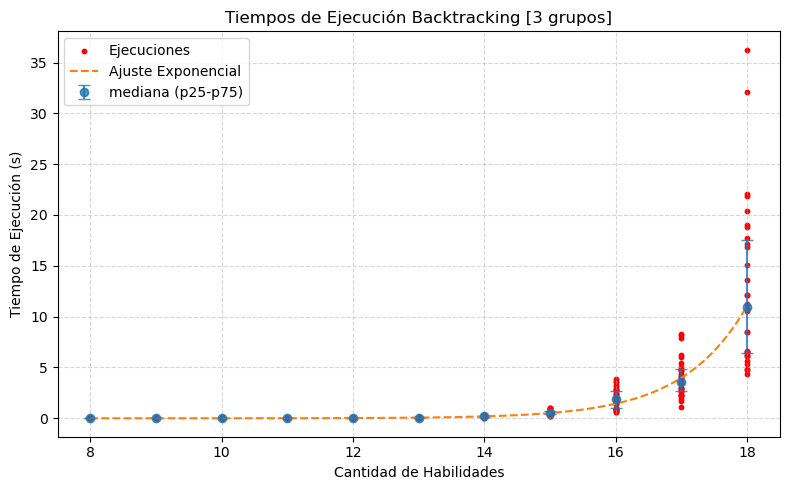

In [12]:
plt.figure(figsize=(8,5))
plt.scatter(df["tam"], df["tiempo"], color='red', s=10, alpha=1, label="Ejecuciones")


plt.errorbar(x, y_med, yerr=[y_med - summary["p25"].values, summary["p75"].values - y_med],
             fmt='o', alpha=.8, capsize=4, label="mediana (p25-p75)")

xs = np.linspace(MIN_TAM, MAX_TAM, 200)
plt.plot(xs, modelo_exponencial(xs), linestyle='--', label=f"Ajuste Exponencial")

plt.xlabel('Cantidad de Habilidades')
plt.ylabel('Tiempo de Ejecución (s)')
plt.title('Tiempos de Ejecución Backtracking [3 grupos]')
plt.legend()
plt.grid(linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("../informe/img/ajuste_backtracking.png", dpi=300, bbox_inches='tight')
plt.show()